<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A4-Neural-Network-Classifier" data-toc-modified-id="A4-Neural-Network-Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A4 Neural Network Classifier</a></span><ul class="toc-item"><li><span><a href="#NeuralNetworkClassifier" data-toc-modified-id="NeuralNetworkClassifier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>NeuralNetworkClassifier</code></a></span></li><li><span><a href="#percent_correct" data-toc-modified-id="percent_correct-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>percent_correct</code></a></span></li><li><span><a href="#Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits" data-toc-modified-id="Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Apply <code>NeuralNetworkClassifier</code> to Images of Handwritten Digits</a></span></li><li><span><a href="#Define-train_for_best_validation-and-apply-to-MNIST-data" data-toc-modified-id="Define-train_for_best_validation-and-apply-to-MNIST-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define <code>train_for_best_validation</code> and apply to MNIST data</a></span></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# A4 Neural Network Classifier

## `NeuralNetworkClassifier`

Starting with the `NeuralNetwork` class defined in Lecture Notes 12, complete the subclass `NeuralNetworkClassifier` as discussed.

## `percent_correct`

When trying to classify real data, we need a way to evaluate our performance.  One way is to just calculate the percent of samples correctly classified, and to show a confusion matrix.  Define the function
`percent_correct(Y, T)`, that returns the percent of samples correctly classified, given `T` as a column matrix of class labels, and `Y` as the column matrix of classes predicted by `use`.

In [1]:
import numpy as np
import sys
import optimizers as opt

class NeuralNetwork():

    def __init__(self, n_inputs, n_hiddens_list, n_outputs):

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(n_hiddens_list) + 1

        self.all_weights, self.Ws = self.make_weights()
        self.initialize_weights()
        self.all_gradients, self.Gs = self.make_weights()

        self.stand_params = None
        self.error_trace = []

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'

    def make_weights(self):
        # Create list of matrix shapes, one per layer
        n_in = self.n_inputs
        units = self.n_hiddens_list + [self.n_outputs]
        shapes = []
        for n_units in units:
            shapes.append((n_in + 1, n_units))
            n_in = n_units

        # Allocate contiguous memory to hold all weights
        n_weights = sum([ni * nu for (ni, nu) in shapes])
        all_weights = np.zeros(n_weights)

        # Create numpy views into this memory with the appropriate
        # shapes to be our weight matrices.
        Ws = []
        first = 0
        for (ni, nu) in shapes:
            n_w = ni * nu
            W = all_weights[first:first + n_w].reshape(ni, nu)
            Ws.append(W)
            first += n_w

        return all_weights, Ws

    def initialize_weights(self):
        for W in self.Ws:
            ni, nu = W.shape
            W[:] = np.random.uniform(-1, 1, size=(ni, nu)) / np.sqrt(ni)
        self.error_trace = []

    def forward(self,Xst):
        Ys = [Xst]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1:
                Y = np.tanh(Y)
            Ys.append(Y)
        return Ys[1:]  # remove X from Ys

    def backward(self, Xst, Tst):
        n_samples = Xst.shape[0]

        Ys = self.forward(Xst)
        Ys = [Xst] + Ys  # Ys now has n_layers + 1 elements.  Ws still has n_layers elements.
        delta = - (Tst - Ys[-1]) / (n_samples * self.n_outputs)
        for layeri in range(self.n_layers)[::-1]:
            X = Ys[layeri]
            self.Gs[layeri][:] = self.add_ones(X).T @ delta
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T
                Y = X  # Ys[layeri]
                delta *= 1 - Ys[layeri] ** 2
            # if layeri < self.n_layers - 1:
            #     delta *= 1 - Y ** 2
        # print(self.all_gradients)
        return self.all_gradients

    def mse(self, Xst, Tst):
        Yst = self.forward(Xst)
        return 0.5 * np.mean((Tst - Yst[-1])**2)

    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        Tst = self.standardize_T(T)

        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)
            
        error_trace = optimizer(self.mse, self.backward, [Xst, Tst],
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        self.error_trace += error_trace
        return self

    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def add_ones(self, X):
        return np.insert(X, 0, 1, axis=1)

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = np.mean(Xstds[Xstds > 0])
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

In [2]:
class NeuralNetworkClassifier(NeuralNetwork):
    def forward(self, Xst):
        forward_layers = super().forward(Xst)
        softmax_layer = self.softmax(forward_layers[-1])
        forward_layers[-1] = softmax_layer
        
        return forward_layers
    
    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        # Tst = self.standardize_T(T)                                  ## CHANGED

        # NEW PART FROM HERE ...
        
        self.classes, counts = np.unique(T, return_counts=True)
        self.most_common_class = self.classes[np.argmax(counts)]

        if self.n_outputs != len(self.classes):
            raise ValueError(f'''In NeuralNetworkClassifier, the number of outputs must equal
the number of classes in the training data. The given number of outputs
is {self.n_outputs} and number of classes is {len(self.classes)}. Try changing
the number of outputs in the call to NeuralNetworkClassifier().''')

        T_ind_vars = self.make_indicator_variables(T)
  
        #   ... TO HERE
        
        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(negLL):
            return np.exp(-negLL)                                                    ## CHANGED
            
        error_trace = optimizer(self.neg_log_likelihood, self.backward, [Xst, T_ind_vars],   ## CHANGED
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        
        self.error_trace += error_trace
        return self

    def make_indicator_variables(self, T):
        '''Assumes argument is N x 1, N samples each being integer class label.'''
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = max(0, np.max(Y))
        expY = np.exp(Y - maxY)
        denom = np.sum(expY, axis=1).reshape((-1, 1)) 
        Y = expY / (denom + sys.float_info.epsilon)             # requires an    import sys
        return Y

    def neg_log_likelihood(self, Xst, T): # T must be indicator variables
         Y = self.forward(Xst)
        #  print("Result of forward call in neg_log_likelihood: ")
        #  print(str(Y) + "\n")

         G = np.log(Y[-1] + sys.float_info.epsilon)
         #print("Result of epsilon call is:")
         #print(str(G) + "\n")
         
         result = -np.mean(G*T)
         #print("Result is: ")
         #print(str(result) + "\n")

         return result

    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]  

        classes = np.argmax(Y, axis=1).reshape(-1,1)
        # print("Classes:")
        # print(classes)

        Zs = Ys[:-1]
        return (classes, Y, Zs) if return_hidden_layer_outputs else (classes, Y)

In [3]:
def percent_correct(Y, T):
    correct_count = 0
    for i in range(len(Y)):
        if(Y[i] == T[i]):
            correct_count += 1
    return 100*(correct_count/len(Y))

In [4]:
import numpy as np

In [5]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
T = np.array([[0], [1], [1], [0]])
X, T

(array([[0, 0],
        [1, 0],
        [0, 1],
        [1, 1]]), array([[0],
        [1],
        [1],
        [0]]))

In [6]:
np.random.seed(111)
nnet = NeuralNetworkClassifier(2, [10], 2)

In [7]:
nnet.Ws

[array([[ 0.12952296, -0.38212533, -0.07383268,  0.31091752, -0.23633798,
         -0.40511172, -0.55139454, -0.09211682, -0.30174387, -0.18745848],
        [ 0.56662595, -0.3028474 , -0.48359706,  0.19583749,  0.13999926,
         -0.26066957, -0.03900416, -0.44067096, -0.49195143,  0.46277416],
        [ 0.33943873,  0.39325596,  0.36397022,  0.56690583,  0.08922813,
          0.36230683, -0.09085429, -0.5456561 , -0.05295844, -0.45573018]]),
 array([[ 0.19129089,  0.11923431],
        [ 0.03936858, -0.13614606],
        [ 0.30059098, -0.21826885],
        [ 0.06959828, -0.00902345],
        [-0.05727085,  0.13739817],
        [-0.10684722, -0.05997329],
        [-0.10916737,  0.26968491],
        [ 0.25249064,  0.18925528],
        [-0.28096209,  0.2673639 ],
        [ 0.27162504,  0.18488136],
        [-0.01128977,  0.2814664 ]])]

If you add some print statements in `neg_log_likelihood` functions, you can compare your output to the following results.

In [8]:
nnet.train(X, T, 1, 0.1, method='sgd')

sgd: Epoch 1 Error=0.69995


NeuralNetwork(2, [10], 2)

In [9]:
np.exp(-0.35674)

0.6999544622383824

Now if you comment out those print statements, you can run for more epochs without tons of output.

In [29]:
np.random.seed(111)
nnet = NeuralNetworkClassifier(2, [10], 2)

In [30]:
nnet.train(X, T, 100, method='scg')

SCG: Epoch 10 Error=0.99066
SCG: Epoch 20 Error=0.99994
SCG: Epoch 30 Error=1.00000


NeuralNetwork(2, [10], 2)

In [31]:
nnet.use(X)

(array([[0],
        [1],
        [1],
        [0]], dtype=int64), array([[9.99999987e-01, 1.28279496e-08],
        [1.01062442e-08, 9.99999990e-01],
        [8.80561778e-09, 9.99999991e-01],
        [9.99999979e-01, 2.13188123e-08]]))

In [32]:
percent_correct(nnet.use(X)[0], T)

100.0

Works!  The XOR problem was used early in the history of neural networks as a problem that cannot be solved with a linear model.  Let's try it.  It turns out our neural network code can do this if we use an empty list for the hidden unit structure!

In [33]:
nnet = NeuralNetworkClassifier(2, [], 2)
nnet.train(X, T, 100)   # default method is 'scg'

NeuralNetwork(2, [], 2)

In [34]:
nnet.use(X)

(array([[0],
        [0],
        [0],
        [0]], dtype=int64), array([[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]]))

In [35]:
percent_correct(nnet.use(X)[0], T)

50.0

A second way to evaluate a classifier is to calculate a confusion matrix. This shows the percent accuracy for each class, and also shows which classes are predicted in error.

Here is a function you can use to show a confusion matrix.

In [17]:
import pandas

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

In [18]:
confusion_matrix(nnet.use(X)[0], T)

Percent Correct


,0,1
0,0.0,100.0
1,0.0,100.0


## Apply `NeuralNetworkClassifier` to Images of Handwritten Digits

Apply your `NeuralNetworkClassifier` to the [MNIST digits dataset](http://deeplearning.net/tutorial/gettingstarted.html).

In [19]:
import pickle
import gzip
import matplotlib.pyplot as plt

In [108]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [21]:
28*28

784

In [22]:
def draw_image(image, label):
    plt.imshow(-image.reshape(28, 28), cmap='gray')
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(label)

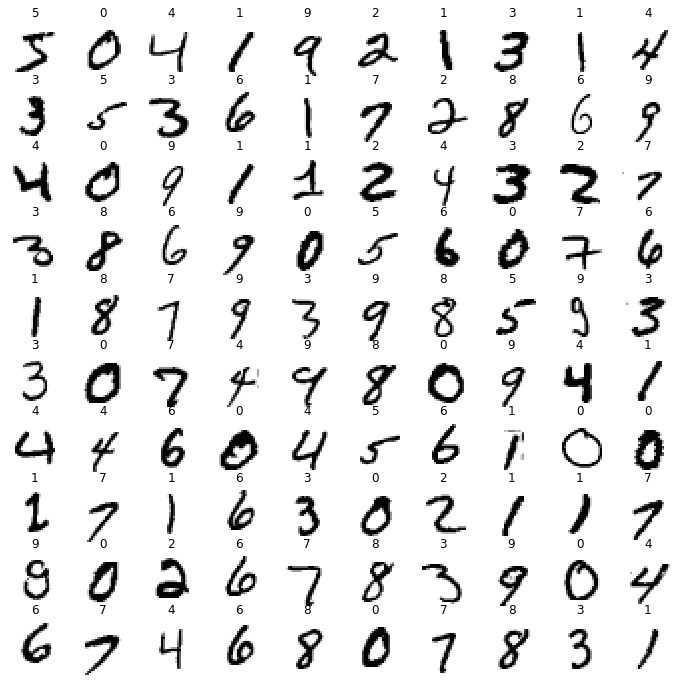

In [23]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    draw_image(Xtrain[i], Ttrain[i,0])

In [24]:
nnet = NeuralNetworkClassifier(784, [], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 4 Error=0.95274
SCG: Epoch 8 Error=0.96850
SCG: Epoch 12 Error=0.97250
SCG: Epoch 16 Error=0.97345
SCG: Epoch 20 Error=0.97345
SCG: Epoch 24 Error=0.97345
SCG: Epoch 28 Error=0.97345
SCG: Epoch 32 Error=0.97427
SCG: Epoch 36 Error=0.97538
SCG: Epoch 40 Error=0.97590


NeuralNetwork(784, [], 10)

In [92]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[93.356, 92.83, 92.42]

In [93]:
nnet = NeuralNetworkClassifier(784, [20], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 4 Error=0.93941
SCG: Epoch 8 Error=0.96456
SCG: Epoch 12 Error=0.97512
SCG: Epoch 16 Error=0.97991
SCG: Epoch 20 Error=0.98276
SCG: Epoch 24 Error=0.98501
SCG: Epoch 28 Error=0.98699
SCG: Epoch 32 Error=0.98857
SCG: Epoch 36 Error=0.98990
SCG: Epoch 40 Error=0.99102


NeuralNetwork(784, [20], 10)

In [94]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest],
                                                    [Ttrain, Tval, Ttest])]

[97.572, 94.32000000000001, 93.82000000000001]

## Define `train_for_best_validation` and apply to MNIST data

Using the function `run` from Lecture Notes 11 as a guide, define a new function `train_for_best_validation` that accepts arguments
* `Xtrain, Ttrain`: matrices of shapes $N\times D$ and $N\times 1$ as input and target training data, where $N$ is number of training samples and $D$ is number of input components,
* `Xval, Tval`: matrices of shapes  $N\times D$ and $N\times 1$ of validation data ($N$ not same value as above)
* `n_epochs`: total number of epochs to train for,
* `n_epochs_per_train`: divide `n_epochs` by this value to get number of times the neural network `train` function is called for this many epochs,
* `n_hiddens_list`: structure of hidden layers,
* `method`: optimizer method,
* `learning_rate`: used for optimizer methods 'adam' and 'sgd'.

It must return 
* `nnet`: resulting neural network with weights that produced the highest accuracy for the validation data set,
* `epoch`: epoch corresponding to best validation accuracy,
* `train_accuracy`: accuracy at that best epoch on training data,
* `val_accuracy`: accuracy at that best epoch on validation data.

This function should call your `percent_correct` function to calculate classification accuracies.

Apply it to the MNIST data as shown below.

In [96]:
def train_for_best_validation(Xtrain, Ttrain, Xval, Tval, n_epochs, n_epochs_per_train, n_hiddens_list, method, learning_rate=None):
    n_reps = n_epochs // n_epochs_per_train
    n_epochs_last_train = n_epochs - n_reps * n_epochs_per_train
    if n_epochs_last_train > 0:
        n_reps += 1
    
    classes = np.max(Ttrain) + 1 
    nnet = NeuralNetworkClassifier(Xtrain.shape[1], n_hiddens_list, classes)

    correct_pairs = []
    for reps in range(n_reps):
        n_epoch = n_epochs_per_train 
        if n_epochs_last_train > 0 and reps == n_reps-1:
            n_epoch = n_epochs_last_train
            
        nnet.train(Xtrain, Ttrain, n_epoch, method='scg', verbose=False)
        percent_correct_train = percent_correct(nnet.use(Xtrain)[0], Ttrain)
        percent_correct_test = percent_correct(nnet.use(Xval)[0], Tval)

        if(reps % 10 == 0):
            print("Reps: " + str(reps))
            print("Train accuracy: " + str(percent_correct_train))
            print("Test accuracy: " + str(percent_correct_test))

        correct_pairs.append([(reps + 1) * n_epoch,
                        percent_correct_train,
                        percent_correct_test])
        
    correct_pairs = np.array(correct_pairs)
    best_test_index = np.argmax(correct_pairs[:, -1])
    best_test_epoch, best_test_train_rmse, best_test_test_rmse = correct_pairs[best_test_index, :]
    print(f'Best test error is at epoch {best_test_epoch}', end='')
    print(f' with percent_correct Train of {best_test_train_rmse:.2f} and Test of {best_test_test_rmse:.2f}')

    plt.plot(correct_pairs[:, 0], correct_pairs[:, 1], label='Train')
    plt.plot(correct_pairs[:, 0], correct_pairs[:, 2], label='Test')
    plt.legend()
    ymin, ymax = plt.ylim()
    plt.plot([best_test_epoch, best_test_epoch], [ymin, ymax], 'r')
    plt.xlabel(f'Epochs')
    plt.ylabel('Percent Correct')

    return nnet, best_test_epoch, best_test_train_rmse, best_test_test_rmse

Epoch: 0
Train accuracy: 92.50399999999999
Test accuracy: 93.14
Epoch: 10
Train accuracy: 98.91799999999999
Test accuracy: 94.19999999999999
Best test error is at epoch 60.0 with percent_correct Train of 97.84 and Test of 94.54


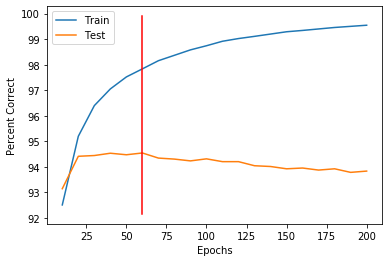

In [90]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20], method='scg') 

In [91]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[99.546, 93.83, 93.73]

Call `train_for_best_validation` a number of times to compare accuracies using the three different optimization methods, and a few different values of `n_epochs`, `n_epochs_per_train`, and `n_hiddens_list`, and `learning_rate` when using 'sgd' and 'adam'.  You do not have to find the very best values of these parameters.  For example, for `n_hiddens_list` at least use `[]` (a linear model) and a larger network, like `[100, 100]`.

Show the confusion matrix for the network that gave you the best validation accuracy.

Write at least 10 sentences about what you observe in the accuracy plots, the train, validation and test accuracies, and the confusion matrix.

Reps: 0
Train accuracy: 92.032
Test accuracy: 92.03
Best test error is at epoch 50.0 with percent_correct Train of 93.68 and Test of 92.97


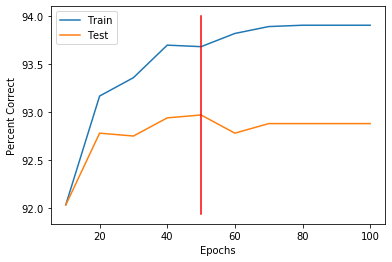

In [100]:
#SCG - linear, smaller n_epochs
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [], method='scg') 

Reps: 0
Train accuracy: 92.684
Test accuracy: 93.24
Best test error is at epoch 90.0 with percent_correct Train of 100.00 and Test of 96.81


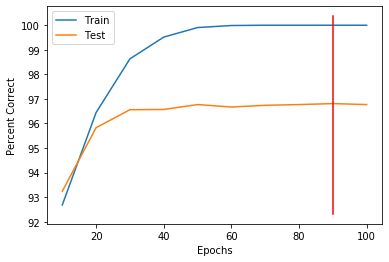

In [101]:
#SCG - large network, smaller n_epochs
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [100,100], method='scg') 

When varying the training parameters *n_hidden_layers* and *n_epochs*, the SCG optimizer saw a drastic difference in validation accuracy - from 92.27% to 96.81%. This should be attributed to the more dense network architecture, clearly enabling the resulting "function" to better fit the hyperplane created by the input data due to more tuning parameters (nodes). Also noteworthy about the change in network architecture is the resulting search time to find the best epoch. 

In the linear network model using the SCG optimizer, the best validation epoch occurred exactly halfway through the search space - at epoch 50. However, during the dense architecture version, the best validation epoch was found near the end of the search space at epoch 90. This is most likely due to the order of magnitude increase in search space for a local minima created by adding nearly 200 nodes in two seperate layers. As this space increases, it is far less likely that the best epoch will be found within the first search intervals.

Reps: 0
Train accuracy: 91.996
Test accuracy: 92.17
Best test error is at epoch 50.0 with percent_correct Train of 93.71 and Test of 92.94


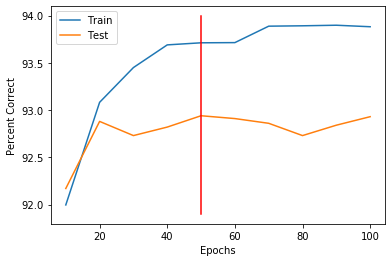

In [103]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [], method='sgd', learning_rate=0.01) 

Reps: 0
Train accuracy: 91.994
Test accuracy: 92.51
Best test error is at epoch 90.0 with percent_correct Train of 100.00 and Test of 97.00


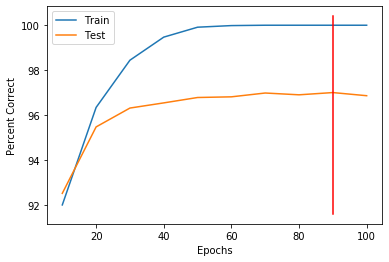

In [109]:
best_nnet, epoch, _ , best_test = nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [100,100], method='sgd', learning_rate=0.01) 

When run with the SGC optimizer, the neural network ultimately displayed very similar behavior to the SCG variant. When adding more nodes and layers, SGD also saw an increase - this time even larger than SCG - in validation accuracy from 92.94% to 97%. Among all optimizers, 97% was the best validation accuracy achieved. The increase can again be attributed to bettering the ability of the resulting network to fit the hyperplane. 

Interestingly, both SCG and SGD displayed the **exact** same behavior in regards to searching for the best epoch. Of course, SGD will also see a lower likelihood of finding the optimal epoch at lower numbers as the search space increases, but in fact it found the optimal epoch at the same position as SCG (epoch 90). This showcases the high similarity of function in SGD and SCG.

Reps: 0
Train accuracy: 92.022
Test accuracy: 92.07
Best test error is at epoch 30.0 with percent_correct Train of 93.29 and Test of 92.95


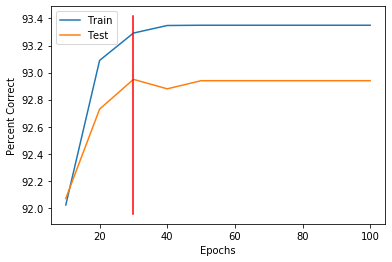

In [105]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [], method='adam', learning_rate=0.01) 

Reps: 0
Train accuracy: 92.438
Test accuracy: 93.06
Best test error is at epoch 70.0 with percent_correct Train of 100.00 and Test of 96.96


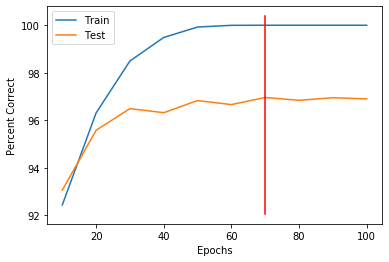

In [104]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [100,100], method='adam', learning_rate=0.01) 

The ADAM optimizer as expected also saw an increase to validation accuracy as nodes/layers were added. The linear model showed an accuracy of 92.95% while the model with two layers of 100 nodes was the second highest overall accuracy at 96.96%. The accuracy increase is due to the same reasoning presented in the SGD and SCG cases. The ADAM optimizers most notable feature comes from distinctly more harsh slopes in the test data at later training epochs in the non-linear model. 

Notice how both the non-linear SGD and SGC have nearly become smooth by the time the *Test* line begins to level off. However, in the case of the ADAM optimizer, there are still easily discernable slope variants in *Test* line after epoch 40. (I believe) these slopes can be attributed to the manner in which ADAM performes accumulation and update of gradient values.

In [112]:
confusion_matrix(best_nnet.use(Xval)[0], Tval)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,98.3,0.0,0.2,0.0,0.2,0.2,0.3,0.1,0.1,0.6
1,0.0,98.8,0.2,0.3,0.0,0.2,0.1,0.4,0.1,0.0
2,0.2,0.1,96.5,0.7,0.2,0.1,0.4,0.8,0.6,0.4
3,0.3,0.0,0.6,96.0,0.0,1.2,0.0,0.1,1.5,0.4
4,0.1,0.4,0.1,0.0,97.7,0.0,0.2,0.1,0.2,1.2
5,0.3,0.1,0.4,1.0,0.3,95.4,1.0,0.1,0.9,0.4
6,0.4,0.0,0.3,0.0,0.3,0.1,98.6,0.0,0.3,0.0
7,0.1,0.2,0.6,0.2,0.4,0.0,0.0,97.6,0.1,0.8
8,0.3,0.3,0.8,1.2,0.1,0.9,0.3,0.1,94.7,1.3
9,0.2,0.2,0.0,0.5,1.7,0.4,0.0,1.7,0.5,94.8


The confusion matrix for all 10 classes (digits 0-9 ironically enough) shows excellent accuracy in every class, with the lowest being the digit '9' and the highest being the digit '1'. Logically, it stands to reason that a digit which bears more resemblance to others would have an overall lower accuracy - a theory that would be supported with the most recognizable digit being '1'. However when it comes to the MNIST dataset, it is composed of *handwritten* digits only. Therefore differences in classes which are within a few percent are more likely due to the available handwritten digit data, and how legible it is in the first place.


======================= Code Execution =======================

Extracting python code from notebook named 'Ridgeway-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    # Is isinstance(nnet, NeuralNetwork) True?


--- 5/5 points. NeuralNetworkClassifier is correctly of type NeuralNetwork

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5)]

## Testing train #######

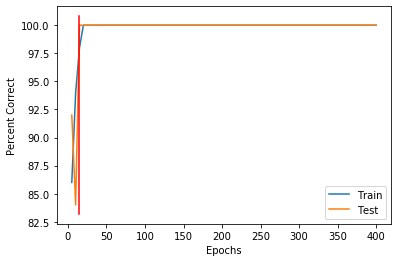

In [113]:
%run -i A4grader.py